# Single Adaptive Matched Filters Using Particle Swarm Optimization and Normal Bhattacharyya Distance

This algorithm has been used to generate the results of the following publication:
<br>
B. A. Semcheddine and A. Daamouche, "Adaptive Matched Filters for VHR Image Classification," 2022 IEEE Mediterranean and Middle-East Geoscience and Remote Sensing Symposium (M2GARSS), Istanbul, Turkey, 2022, pp. 50-53, doi: 10.1109/M2GARSS52314.2022.9839931.

<br>
Please note that the dataset isn't the same as in the publication.
<br><br>
Please cite the following, if you are to use the dataset image:
<br>
R. C. Daudt, B. Le Saux, A. Boulch, and Y. Gousseau, “Multitask learning for large-scale semantic
change detection,” Computer Vision and Image Understanding, vol. 187, p. 102783, 2019. doi: 10.1016/j.cviu.2019.07.003

## Libraries Import

In [50]:
## Imports
import os 
import random
import time

import multiprocess as mp
from functools import partial

import numpy as np
from numpy import zeros, mean, round, concatenate
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC # SVM Classifier
from sklearn.model_selection import cross_val_score, GridSearchCV # maybe?

import scipy
from scipy.ndimage import convolve
import cv2
import matplotlib.pyplot as plt

from PIL import Image

from math import gamma, sin, pi, pow

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import rectangle

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed

## Loading dataset and ground truth

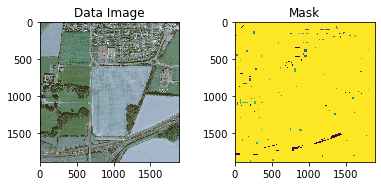

In [25]:
# Reading all data and retrieving labels
# CALVADOS Image
data_path = "CALVADOS_dataset"

ids_image = "A3"
ids_mask = "A3_mask4"

image_path = os.path.join(data_path, ids_image) + ".tif"
mask_path = os.path.join(data_path, ids_mask) + ".png"

image = cv2.imread(image_path, -1)
mask = cv2.imread(mask_path, 0)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
plt.title("Data Image")
ay = fig.add_subplot(1, 2, 2)
ay.imshow(mask)
plt.title("Mask")

image = image/255.0

## Labels from ground truth mask

In [26]:
samples_labels = list(np.unique(mask))
samples_labels.remove(255)
class_labels = list(range(1,len(samples_labels)+1))
print("labels in mask: ", samples_labels)
print("Class labels: ", class_labels)

labels in mask:  [29, 32, 91, 96, 123, 137, 155, 174, 179, 192]
Class labels:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Custom functions

### Extracting train and test samples function

In [43]:
def get_train_test_data_35_65(image_, denom) :
    # this function divided the data 35/65
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    c = 1

    for l in samples_labels:
        data = image_[mask==l]
        steps = list(range(1,denom,3))
        m2 = np.zeros(len(data),  dtype=bool)
        lengt = len(data)
        for i in steps:
            j1 = int(np.round((i/denom)*lengt))
            j2 = int(np.round(((i+2)/denom)*lengt))-1
            m2[j1:j2] = 1
        train_data.append(data[~m2])
        train_labels.append(c*np.ones(len(data[~m2]), dtype=np.uint8))
        test_data.append(data[m2])
        test_labels.append(c*np.ones(len(data[m2]), dtype=np.uint8))
        c = c + 1

    X_tr = train_data[0]
    y_tr = train_labels[0]
    X_ts = test_data[0]
    y_ts = test_labels[0]
    for c in class_labels: 
        if c < len(class_labels):
            X_tr = np.concatenate((X_tr, train_data[c]), axis=0)
            y_tr = np.concatenate((y_tr, train_labels[c]), axis=0)
            X_ts = np.concatenate((X_ts, test_data[c]), axis=0)
            y_ts = np.concatenate((y_ts, test_labels[c]), axis=0)
            
    return X_tr, y_tr, X_ts, y_ts

### Bhattacharyya distance function

In [28]:
def bhattacharyya_dist(dist_1, dist_2):
    # dist has the shape: n_pixels x n_features
    mu_1 = np.zeros((dist_1.shape[1], 1))
    mu_2 = np.zeros((dist_2.shape[1], 1))
    for i in range(0, dist_1.shape[1]):
        mu_1[i,0] = np.mean(dist_1[:,i])  # shape: n_features x 1
        mu_2[i,0] = np.mean(dist_2[:,i])
        
    sigma_1 = np.cov(np.transpose(dist_1))
    sigma_2 = np.cov(np.transpose(dist_2))
    sigma = 0.5*(sigma_1 + sigma_2)
    
    if(np.linalg.matrix_rank(sigma_1)<=1 or np.linalg.matrix_rank(sigma_2)<=1 or np.linalg.matrix_rank(sigma)<=1):
        distance = 0
    else:
        A = np.matmul(np.matmul(np.transpose(mu_1 - mu_2),np.linalg.inv(sigma)),(mu_1 - mu_2))
        t = np.linalg.slogdet(sigma)
        m = np.linalg.slogdet(sigma_1)
        n = np.linalg.slogdet(sigma_2)
        B = t[1] - 0.5*m[1] - 0.5*n[1]
        d = 0.125*A + 0.5*B
        distance = d[0][0]
    return distance

### Bhattacharyya distance cost function

In [29]:
def bhattacharyya_cost(features, labels):
    data_arr = []
    for l in class_labels:
        s = features[labels == l]
        data_arr.append(s)
    classes_distance_perclass = [] # np.zeros(((len(class_labels) - 1), 1))
    for l1 in list(range(1, len(class_labels))):
        for l2 in list(range(l1+1, len(class_labels) + 1)):
            classes_distance_perclass.append(bhattacharyya_dist(data_arr[l1-1], data_arr[l2-1])) 
            
    return np.mean(classes_distance_perclass)

### Accuracy report function

In [52]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label-1,label-1]/np.sum(cm[label-1,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

### Parallel convolution function

In [31]:
class Parallel():
    def __init__(self):
        self.convolve = convolve
        self.min = np.min
        self.max = np.max
        self.ones = np.ones
    
    def conv_filter_frame(self, frame, filter_h):
        conv = self.convolve(frame, filter_h,mode='nearest')
        min_val = self.min(conv)
        if min_val < 0:
            scaled_conv = conv - min_val*self.ones(conv.shape)
            scaled_conv = scaled_conv/self.max(scaled_conv)
        else:
            scaled_conv = conv/self.max(conv)
        return scaled_conv
    
def conv_filter_mp(image_, h) :
    rows, cols, nb_channels = image_.shape
    conv_results = np.zeros((rows, cols, nb_channels))
    channels = list(range(0,nb_channels))
    image_OF_MF = image_
    PROCESSES = 5
    p = Parallel()
    to_use_image = []
    for c in channels:
        to_use_image.append(image_[:,:,c])
    with mp.Pool(PROCESSES) as pool:
        conv_partial = partial( p.conv_filter_frame, filter_h=h )
        results = pool.map( conv_partial,  to_use_image)
        for c in channels:
            m = results[c]
            image_OF_MF = np.concatenate((image_OF_MF,m[:,:,np.newaxis]), axis=-1 )
    return  image_OF_MF

### Predicted labels to RGB

In [ ]:
def label2rgb(image_) :
    rgb_labels=[[0, 0, 255],[100,0,15],[255, 127, 39],[255,0,176],[34, 177, 76],[185, 122, 87],
                [237, 28, 36],[191, 183, 81],[0,255,255] ,[181, 230, 29],[200,191,231]]
    rgb_labels = np.array(rgb_labels)
    length, width = np.array(image_).shape
    nbr_channels = 3
    channels = [0,1,2]
    output_image = np.zeros((length, width, nbr_channels))
    for channel in channels :
        layer = np.zeros((length, width))
        for i in class_labels:
            layer[image_==i] = rgb_labels[i-1][channel]
        output_image[:,:,channel] = layer
    return output_image.astype(np.uint8)

## Details about the number of samples for train and test sets

In [32]:
train_test_det = pd.DataFrame(data=np.zeros((len(class_labels), 3), dtype=np.uint16), 
                  columns=["train", "test", "total"], 
                  index=["class "+str(i+1) for i in range(10)])

In [33]:
denom = 24
X_tr, y_tr, X_ts, y_ts = get_train_test_data_35_65(image, denom)
for i in list(range(0, len(class_labels))):
    nbr_train = len(y_tr[y_tr == (i + 1)])
    nbr_test = len(y_ts[y_ts == (i + 1)])
    total = nbr_train + nbr_test
    train_test_det.iloc[i] = [nbr_train, nbr_test, total]
train_test_det

,train,test,total
class 1,7778,15530,23308
class 2,964,1901,2865
class 3,4124,8224,12348
class 4,120,216,336
class 5,791,1559,2350
class 6,1634,3242,4876
class 7,936,1856,2792
class 8,1833,3640,5473
class 9,1366,2708,4074
class 10,1050,2076,3126


## PSO framework

### Parameters initialization

In [23]:
n = 30

Lb = -1  # Lower bound
Ub = 1 # Upper bound

iter_max = 50

c1 = 2.0
c2 = 2.0
w_max = 0.9
w_min = 0.4

nd = 33 # filter size

### Swarm initialization

In [13]:
global_best_position= np.zeros((nd,nd))
global_best_cost = 0 

position_vect = []
best_position_vect = []
velocity_vect = []
cost_vect = np.zeros(n)
best_cost_vect = np.zeros(n)

for i in range(0,n):
    # initialize position and velocity
    initial_position = Lb+(Ub-Lb) * np.random.rand(nd, nd) 
    initial_velocity = np.zeros((nd,nd))
    
    # run convolution and compute cost
    image_OF_MF = conv_filter_mp(image, initial_position)
    X_tr, y_tr, X_ts, y_ts = get_train_test_data_35_65(image_OF_MF, denom)
    dist = bhattacharyya_cost(X_tr, y_tr)
    
    # add the particle's composants to their respective vectors 
    position_vect.append(initial_position)
    best_position_vect.append(initial_position.copy())
    velocity_vect.append(initial_velocity)
    cost_vect[i] = dist
    best_cost_vect[i] = dist
    
    if dist > global_best_cost:
        global_best_cost = dist
        global_best_position = initial_position.copy()
        
    print(" particle: ", i, " cost = ", "{:.2f}".format(dist))

print("_______________________________________________________________________")

print("Best init cost  = ", global_best_cost)
    
hist_fitness = np.zeros(iter_max)
hist_fitness[0] = global_best_cost

### PSO optimization loop

In [ ]:
for itr in range(1, iter_max):
    print("iteration ", itr)
    
    w = w_max - (w_max - w_min)*(itr/iter_max)
    
    for p in range(0, n):
        position = position_vect[p]
        best_position = best_position_vect[p]
        velocity = velocity_vect[p]
        
        for x in range(0, velocity.shape[0]):
            for y in range(0, velocity.shape[1]):
                r1 = np.random.rand()
                r2 = np.random.rand()
        
                velocity[x,y] = w*velocity[x,y] + c1*r1*(best_position[x,y] - position[x,y]
                                              ) + c2*r2*(global_best_position[x,y] - position[x,y])
        position = position + velocity
        position = position/(np.max(np.abs(position)))
            
        image_OF_MF = conv_filter_mp(image, position)
        X_tr_OF_MF, y_tr, _, _ = get_train_test_data_35_65(image_OF_MF, denom)
        dist = bhattacharyya_cost(X_tr_OF_MF, y_tr)
        
        position_vect[p] = position
        velocity_vect[p] = velocity
        cost_vect[p] = dist
        
        if (dist > best_cost_vect[p]):
            best_position_vect[p] = position.copy()
            best_cost_vect[p] = dist
            
            if (dist > global_best_cost):
                global_best_position = position.copy()
                global_best_cost = dist
                print("Global best updated")

Global best updated
iteration:  66  best cost:  51.08592822709816  svm train:  97.65 svm test: 91.95
iteration:  67  best cost:  51.08592822709816  svm train:  97.65 svm test: 91.95
iteration:  68  best cost:  51.08592822709816  svm train:  97.65 svm test: 91.95
Global best updated
iteration:  69  best cost:  51.208553686772866  svm train:  97.66 svm test: 92.18
Global best updated
iteration:  70  best cost:  51.49656378907672  svm train:  97.67 svm test: 91.97
Global best updated
iteration:  71  best cost:  51.50940049210706  svm train:  97.64 svm test: 92.08
iteration:  72  best cost:  51.50940049210706  svm train:  97.64 svm test: 92.08
iteration:  73  best cost:  51.50940049210706  svm train:  97.64 svm test: 92.08
iteration:  74  best cost:  51.50940049210706  svm train:  97.64 svm test: 92.08
iteration:  75  best cost:  51.50940049210706  svm train:  97.64 svm test: 92.08
Global best updated
iteration:  76  best cost:  51.78309597930521  svm train:  97.61 svm test: 91.95
Global b

## Results

### Numerical results

In [54]:
svm_model = SVC(kernel="rbf", C=200, gamma=2)

## original spectral features
X_tr, y_tr, X_ts, y_ts = get_train_test_data_35_65(image, denom)
svm_model.fit(X_tr, y_tr)
y_pred_OF = svm_model.predict(X_ts)
acc_results_OF = accuracy_report(y_ts, y_pred_OF)
acc_results_all = pd.DataFrame(data=acc_results_OF.values(), 
                               columns=["OF"], index=acc_results_OF.keys())

## Fusion of original spectral features and morphological opening
selem = rectangle(nd,nd)
image_OF_MO = image

image_MO = np.zeros(image.shape)
for channel in range(0, image.shape[2]):
    image_MO[:,:,channel] = opening(image[:,:,channel], selem)
image_OF_MO = np.concatenate((image_OF_MO,image_MO), axis=-1 )

X_tr_OF_MO, _, X_ts_OF_MO, _ = get_train_test_data_35_65(image_OF_MO, denom)
svm_model.fit(X_tr_OF_MO, y_tr)
y_pred_OF_MO = svm_model.predict(X_ts_OF_MO)
acc_results_MO = accuracy_report(y_ts, y_pred_OF_MO)

acc_results_all["MO"] = acc_results_MO.values()

## Fusion of original features and PSO-Bh extracted features
image_OF_PSO_Bh = conv_filter_mp(image, global_best_position)
X_tr_OF_PSO_Bh, _, X_ts_OF_PSO_Bh, _ = get_train_test_data_35_65(image_OF_PSO_Bh, denom)
svm_model.fit(X_tr_OF_PSO_Bh, y_tr)
y_pred_OF_PSO_Bh = svm_model.predict(X_ts_OF_PSO_Bh)
acc_results_PSO_Bh = accuracy_report(y_ts, y_pred_OF_PSO_Bh)

acc_results_all["PSO-Bh"] = acc_results_PSO_Bh.values()

acc_results_all

,OF,MO
class 1,87.250483,90.515132
class 2,82.693319,82.219884
class 3,49.902724,49.927043
class 4,79.166667,84.259259
class 5,91.404747,94.804362
class 6,99.012955,95.280691
class 7,59.159483,67.564655
class 8,84.615385,92.692308
class 9,93.500739,94.276219
class 10,99.759152,99.710983


### Visual results

#### Generating the respective classification maps

In [ ]:
## original spectral features
X_ts_map_OF = np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))
svm_model.fit(X_tr, y_tr)
y_pred_map_OF = svm_model.predict(X_ts_map_OF)
map_OF = np.reshape(y_pred_map_OF, (image.shape[0], image.shape[1]))
map_rgb_OF = labels2rgb(map_OF)

## fusion of original spectral features and morphological opening features
X_ts_map_OF_MO = np.reshape(image_OF_MO, (image_OF_MO.shape[0]*image_OF_MO.shape[1], image_OF_MO.shape[2]))
svm_model.fit(X_tr_OF_MO, y_tr)
y_pred_map_OF_MO = svm_model.predict(X_ts_map_OF_MO)
map_OF_MO = np.reshape(y_pred_map_OF_MO, (image.shape[0], image.shape[1]))
map_rgb_OF_MO = labels2rgb(map_OF_MO)

## fusion of original spectral features and morphological opening features
X_ts_map_OF_PSO_Bh = np.reshape(image_OF_PSO_Bh, 
                                (image_OF_PSO_Bh.shape[0]*image_OF_PSO_Bh.shape[1], image_OF_PSO_Bh.shape[2]))
svm_model.fit(X_tr_OF_PSO_Bh, y_tr)
y_pred_map_OF_PSO_Bh = svm_model.predict(X_ts_map_OF_PSO_Bh)
map_OF_PSO_Bh = np.reshape(y_pred_map_OF_PSO_Bh, (image.shape[0], image.shape[1]))
map_rgb_OF_PSO_Bh = labels2rgb(map_OF_PSO_Bh)

#### Displaying the respective classification maps (per area)

In [ ]:
## Area 1
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(map_rgb_OF[:915, :915,:])
ax1.set_title("Original Spectral Features")
ax2.imshow(map_rgb_OF_MO[:915, :915,:])
ax2.set_title("Morphological opening")
ax3.imshow(map_rgb_OF_PSO_Bh[:915, :915,:])
ax3.set_title("PSO-Bh")
plt.title('SVM prediction of Area 1 using different features')
plt.show()
## Area 2
## Area 3
## Area 4